In [102]:
#read data files
import pandas as pd
brandlist=range(0,3)
df_email=pd.DataFrame()
for name in brandlist:
    datafile='https://sandbox-dojo-recruiting.s3.amazonaws.com/shoppers_email_hashes_brand_{}.csv'.format(name)
    df_tem=pd.read_csv(datafile)

    # Add the brand of the input as a column of the data frame for future reference.
    df_tem['brand']=name 
    df_email=df_email.append(df_tem)  

In [103]:
#start db connections and add the email hash as a table for future join need 
import sqlite3
db_conn=sqlite3.connect('transactions.db')
df_email.to_sql('emails',db_conn,if_exists='replace',index=False)
db_conn.commit()

In [104]:
#identify the per catrgory spendings as features and merge into dataframe
results=pd.read_sql_query('''SELECT e.email_hash,
count(t.spent) AS nb_total_trans, 
SUM(t.spent) AS amt_total_spend,
SUM(case when t.category = 'cleaning-supplies' then t.spent else 0 end) amt_cleaning_supplies_spend,
SUM(case when t.category = 'electronics'       then t.spent else 0 end) amt_electronics_spend,
SUM(case when t.category = 'food'              then t.spent else 0 end) amt_food_spend,
SUM(case when t.category = 'furniture'         then t.spent else 0 end) amt_furniture_spend
FROM emails as e
INNER JOIN transactions AS t
ON e.email_hash = t.email_hash
GROUP BY e.email_hash;
''', db_conn)
df_email=pd.merge(df_email,results, how="inner",on='email_hash')

In [105]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


In [106]:
#identify 3 clusters using all the identified data
X = df_email[df_email.columns[2:8]]
std = StandardScaler()
std.fit(X.values)
X_s=std.transform(X.values)
num_clusters = 3
km = KMeans(n_clusters=num_clusters,random_state=10,n_init=5) # n_init, number of times the K-mean algorithm will run
km.fit(X_s)

KMeans(n_clusters=3, n_init=5, random_state=10)

In [113]:
#Dimension reduction down to 2 dimensions only for display purpose
from sklearn.decomposition import NMF, TruncatedSVD
#reduce to 2 dimensions
display_model=TruncatedSVD(2)
display_dimensions=display_model.fit_transform(X_s)

In [114]:
df_dim=pd.DataFrame(display_dimensions)
df=pd.concat([df_email,df_dim],axis=1)

In [109]:
import matplotlib.pyplot as plt
# helper function that allows us to display data in 2 dimensions an highlights the clusters
def display_cluster(X,km=[],num_clusters=0):
    color = 'brgcmyk'
    alpha = 0.3
    s = 15
    if num_clusters == 0:
        plt.scatter(X[:,0],X[:,1],c = color[0],alpha = alpha,s = s)
    else:
        for i in range(num_clusters):
            plt.scatter(km.cluster_centers_[i][0],km.cluster_centers_[i][1],c = color[i], marker = 'x', s = 100)
            plt.scatter(X[km.labels_==i,0],X[km.labels_==i,1],c = color[i],alpha = alpha,s=s)


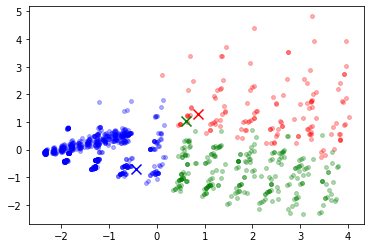

In [115]:
display_cluster(display_dimensions,km,3)

In [111]:
db_conn.close()

In [117]:
df.to_csv('data.csv')